###  Bin y, estimate E[zz⊤] within each bin, and reconstruct in the same form


[SSE / binning] Subspace alignment (mean singular value): 0.0327
[Saved] fig_sse_binning_spectrum_n10000_d1000_p2_bins50.png


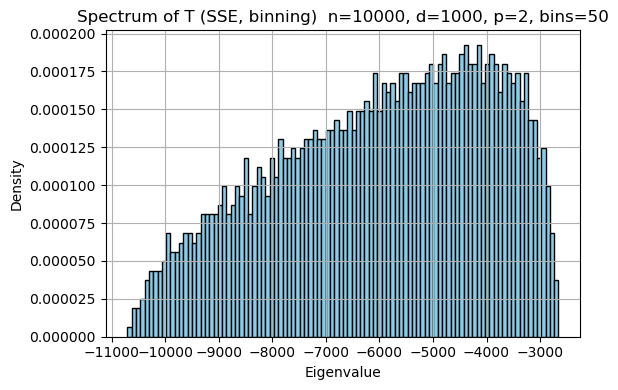

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Set parameters and random seed
np.random.seed(42)
n = 10000             # Number of samples
d = 1000              # Input dimension
p = 2                 # Subspace dimension (index dimension)
alpha = n / d         # Sampling ratio
num_bins = 50         # Number of bins
min_bin = 20          # Minimum samples per bin (to avoid instability)
ridge_eps = 1e-3      # Ridge regularization for numerical stability
save_fig = True       # Whether to save the figure

# Construct ground-truth signal subspace W* (orthonormal columns)
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)   # Orthogonalize to avoid collinearity

# Generate samples (x_i, y_i)
X = np.random.randn(n, d) / np.sqrt(d)   # X_i ~ N(0, I/d)
Z = X @ W_star                           # (n, p)
y = Z[:, 0] * Z[:, 1]                    # g(z1, z2) = z1 * z2

# Bin-based estimation of G(y) = E[zz^T | y] - I
# Important: use second moments instead of covariance to preserve E[z|y]E[z|y]^T
y_bins = np.linspace(y.min(), y.max(), num_bins + 1)
bin_ids = np.clip(np.digitize(y, y_bins) - 1, 0, num_bins - 1)

G_list = []
I_p = np.eye(p)
for b in range(num_bins):
    idx = np.where(bin_ids == b)[0]
    if len(idx) < min_bin:
        # For bins with insufficient samples, return zero matrix (conservative estimate)
        G_list.append(np.zeros((p, p)))
        continue
    Z_bin = Z[idx]                                  # (m, p)
    second_moment = (Z_bin.T @ Z_bin) / len(idx)    # E[zz^T | bin]
    G_list.append(second_moment - I_p)              # G = E[zz^T|y] - I

# Precompute T(y_i) = G (G + I)^{-1} with ridge regularization
Tys = np.zeros((n, p, p))
for i in range(n):
    G_y = G_list[bin_ids[i]]
    # Use solve instead of inv for better numerical stability; add ridge for regularization
    Tys[i] = G_y @ np.linalg.solve(G_y + (1.0 + ridge_eps) * I_p, I_p)

# Vectorized construction of symmetric spectral matrix T ∈ ℝ^{(dp)×(dp)}
# Each block: T_(mu,nu) = X^T diag(Tys[:,mu,nu]) X
blocks = [[None] * p for _ in range(p)]
for mu in range(p):
    for nu in range(p):
        w = Tys[:, mu, nu]                  # (n,)
        blocks[mu][nu] = X.T @ (w[:, None] * X)   # (d,d)
T = np.block(blocks)                         # (d*p, d*p)
T = 0.5 * (T + T.T)                         # Optional symmetrization to reduce numerical drift

# Top eigenvector to estimate subspace
eigval, eigvec = eigsh(T, k=1, which='LA')         # Leading eigenvector
W_hat = eigvec[:, 0].reshape(d, p)

# Column orthogonalization (Procrustes) for best p-dimensional basis
U, _, Vt = np.linalg.svd(W_hat, full_matrices=False)
W_hat = U @ Vt                                     # (d,p), orthonormal

# Evaluate subspace alignment (mean singular value)
overlap = W_hat.T @ W_star
_, s, _ = np.linalg.svd(overlap)
alignment = np.mean(s)                              # Closer to 1 indicates better recovery
print(f"[SSE / binning] Subspace alignment (mean singular value): {alignment:.4f}")

# Visualize eigenvalue distribution and save figure
plt.figure(figsize=(6, 4))
plt.title(f"Spectrum of T (SSE, binning)  n={n}, d={d}, p={p}, bins={num_bins}")
plt.hist(np.linalg.eigvalsh(T), bins=100, density=True, color="skyblue", edgecolor="k")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()

if save_fig:
    fname = f"fig_sse_binning_spectrum_n{n}_d{d}_p{p}_bins{num_bins}.png"
    plt.savefig(fname, dpi=160)
    print(f"[Saved] {fname}")

plt.show()


Subspace alignment (mean singular value): 0.0298


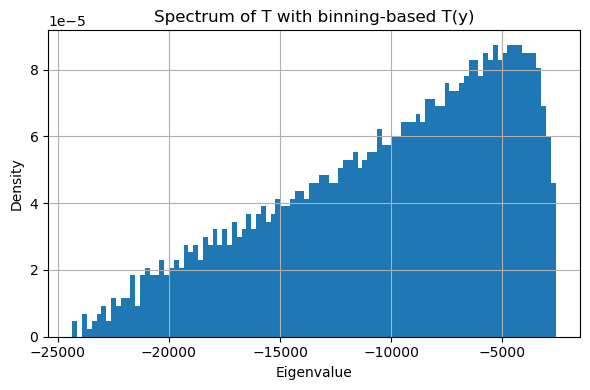

In [ ]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Set parameters
n = 5000   # Number of samples
d = 1000   # Input dimension
p = 2      # Subspace dimension (index dimension)
alpha = n / d  # Sampling ratio

np.random.seed(42)

# Construct ground-truth signal subspace W*
W_star = np.random.randn(d, p)
W_star /= np.linalg.norm(W_star, axis=0)

# Generate samples (x_i, y_i)
X = np.random.randn(n, d) / np.sqrt(d)        # X_i ~ N(0, I/d)
Z = X @ W_star                                # Shape: (n, p)
y = Z[:, 0] * Z[:, 1]                         # g(z1, z2) = z1 * z2

# Estimate G(y_i) = E[zz^T | y_i] - I using binning
num_bins = 50
y_bins = np.linspace(np.min(y), np.max(y), num_bins + 1)
bin_ids = np.digitize(y, y_bins) - 1
bin_ids = np.clip(bin_ids, 0, num_bins - 1)  # Prevent out-of-range indexing

# Compute E[zz^T | bin] - I for each bin
G_list = []
for i in range(num_bins):
    idx = np.where(bin_ids == i)[0]
    if len(idx) < 10:
        G_list.append(np.zeros((p, p)))
        continue
    Z_bin = Z[idx]
    cov = np.cov(Z_bin.T)
    G_list.append(cov - np.eye(p))

# Construct symmetric spectral matrix T ∈ ℝ^{dp × dp}
T = np.zeros((d * p, d * p))

for i in range(n):
    bin_idx = bin_ids[i]
    G_y = G_list[bin_idx]
    T_y = G_y @ np.linalg.inv(G_y + np.eye(p))  # T(y) = G(G + I)^{-1}

    xi = X[i].reshape(-1, 1)  # d×1
    for mu in range(p):
        for nu in range(p):
            T_block = T_y[mu, nu] * (xi @ xi.T)  # d×d
            row_start = mu * d
            col_start = nu * d
            T[row_start:row_start+d, col_start:col_start+d] += T_block

# Compute the leading eigenvector (associated with the largest eigenvalue)
eigval, eigvec = eigsh(T, k=1, which='LM')
w_hat = eigvec[:, 0]
W_hat = w_hat.reshape(d, p)
W_hat /= np.linalg.norm(W_hat, axis=0)  # Normalize columns

# Evaluate subspace recovery performance
overlap_matrix = W_hat.T @ W_star
u, s, vh = np.linalg.svd(overlap_matrix)
alignment = np.mean(s)  # Closer to 1 indicates better recovery
print(f"Subspace alignment (mean singular value): {alignment:.4f}")

# Visualize spectrum distribution
plt.figure(figsize=(6, 4))
plt.title("Spectrum of T with binning-based T(y)")
plt.hist(np.linalg.eigvalsh(T), bins=100, density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


Subspace alignment (mean singular value): 0.0298


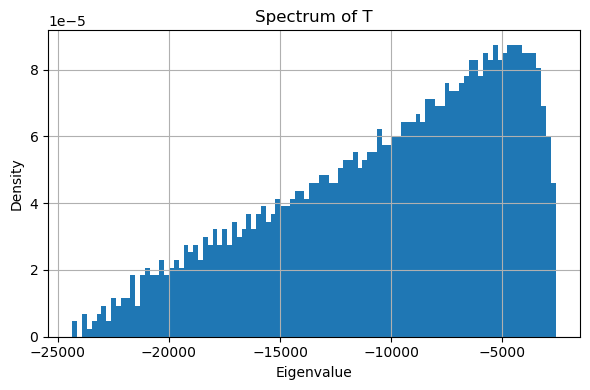

In [ ]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Set parameters
n = 5000   # Number of samples
d = 1000   # Input dimension
p = 2      # Subspace dimension (index dimension)
alpha = n / d  # Sampling ratio

np.random.seed(42)

# Construct ground-truth signal subspace W*
W_star = np.random.randn(d, p)
W_star /= np.linalg.norm(W_star, axis=0)

# Generate samples (x_i, y_i)
X = np.random.randn(n, d) / np.sqrt(d)        # X_i ~ N(0, I/d)
Z = X @ W_star                                # Shape: (n, p)
y = Z[:, 0] * Z[:, 1]                         # g(z1, z2) = z1 * z2

# Estimate G(y_i) = E[zz^T | y_i] - I using binning
num_bins = 50
y_bins = np.linspace(np.min(y), np.max(y), num_bins + 1)
bin_ids = np.digitize(y, y_bins) - 1
bin_ids = np.clip(bin_ids, 0, num_bins - 1)  # Prevent out-of-range indexing

# Compute E[zz^T | bin] - I for each bin
G_list = []
for i in range(num_bins):
    idx = np.where(bin_ids == i)[0]
    if len(idx) < 10:
        G_list.append(np.zeros((p, p)))
        continue
    Z_bin = Z[idx]
    cov = np.cov(Z_bin.T)
    G_list.append(cov - np.eye(p))

# Construct symmetric spectral matrix T ∈ ℝ^{dp × dp}
T = np.zeros((d * p, d * p))

for i in range(n):
    bin_idx = bin_ids[i]
    G_y = G_list[bin_idx]
    T_y = G_y @ np.linalg.inv(G_y + np.eye(p))  # T(y) = G(G + I)^{-1}

    xi = X[i].reshape(-1, 1)  # d×1
    for mu in range(p):
        for nu in range(p):
            T_block = T_y[mu, nu] * (xi @ xi.T)  # d×d
            row_start = mu * d
            col_start = nu * d
            T[row_start:row_start+d, col_start:col_start+d] += T_block

# Compute the leading eigenvector (associated with the largest eigenvalue)
eigval, eigvec = eigsh(T, k=1, which='LM')
w_hat = eigvec[:, 0]
W_hat = w_hat.reshape(d, p)
W_hat /= np.linalg.norm(W_hat, axis=0)  # Normalize each column

# Evaluate subspace recovery performance
overlap_matrix = W_hat.T @ W_star
u, s, vh = np.linalg.svd(overlap_matrix)
alignment = np.mean(s)  # Closer to 1 indicates better recovery
print(f"Subspace alignment (mean singular value): {alignment:.4f}")

# Visualize eigenvalue distribution
plt.figure(figsize=(6, 4))
plt.title("Spectrum of T")
plt.hist(np.linalg.eigvalsh(T), bins=100, density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()
